# Epipolar_Geometry.ipynb  
By: Shawn Vosburg (260743167)  
Due: November 5th, 2018  
Course: ECSE415, McGill University  

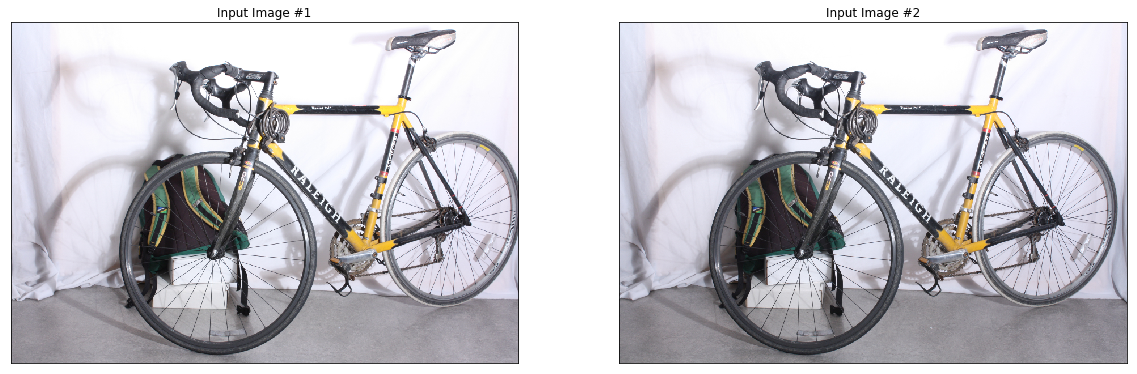

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#obtain images and depth map
img0 = cv2.imread('im0.png');
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.imread('im1.png');
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# resize images for fast processing
img0 = cv2.resize(img0, None, fx=0.3, fy=0.3)
img1 = cv2.resize(img1, None, fx=0.3, fy=0.3)


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0)
plt.title("Input Image #1"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(img1)
plt.title("Input Image #2"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2.1 Compute matching SIFT keypoints from a stereo image pair.

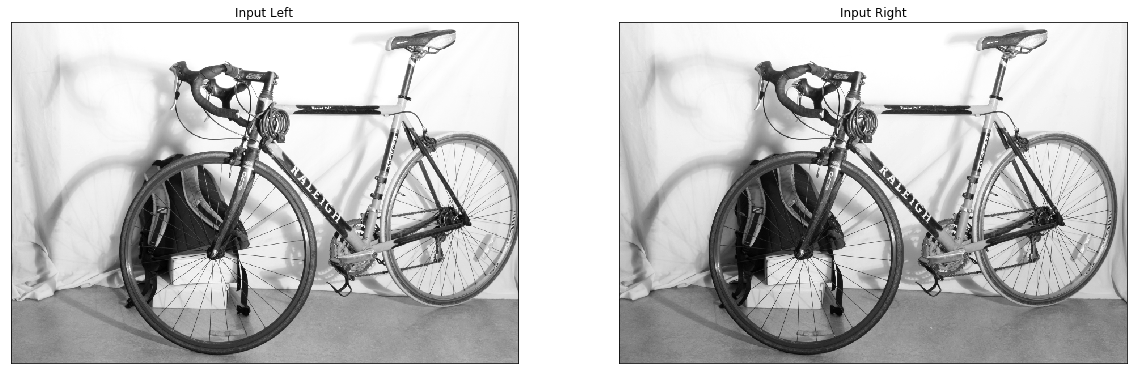

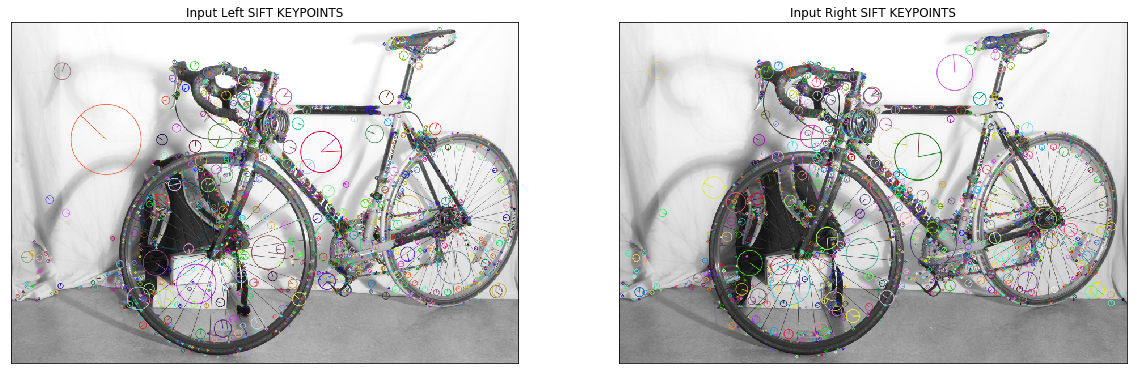

In [3]:
#Save copies of the input images
img0S = img0.copy()
img1S = img1.copy()
img0_disp = img0S.copy()
img1_disp = img1S.copy()

img0S = cv2.cvtColor(img0S, cv2.COLOR_RGB2GRAY)
img1S = cv2.cvtColor(img1S, cv2.COLOR_RGB2GRAY)

#Creating sift object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
keypoints1, descriptors1 = sift.detectAndCompute(img0S, None)
keypoints2, descriptors2 = sift.detectAndCompute(img1S, None)


# draw the keypoints. 3rd argument is outputimage. 
cv2.drawKeypoints(img0S, keypoints1, img0_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img1S, keypoints2, img1_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display keypoints as a visual check.
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img0S,cmap="gray")
plt.title("Input Left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img1S,cmap="gray")
plt.title("Input Right"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img0_disp)
plt.title("Input Left SIFT KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img1_disp)
plt.title("Input Right SIFT KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.show()


## 2.2.2 Compute and display the epipolar lines for both images.

In [4]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    r, c = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

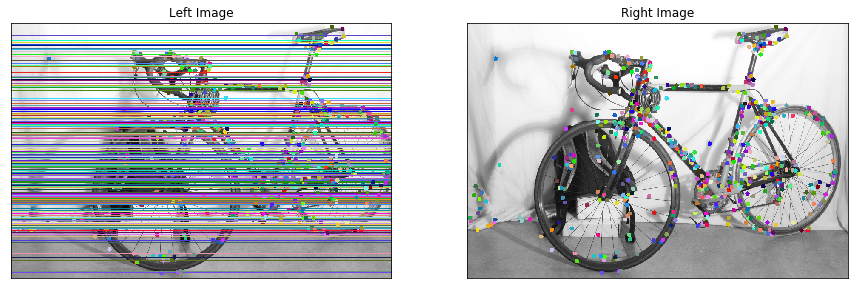

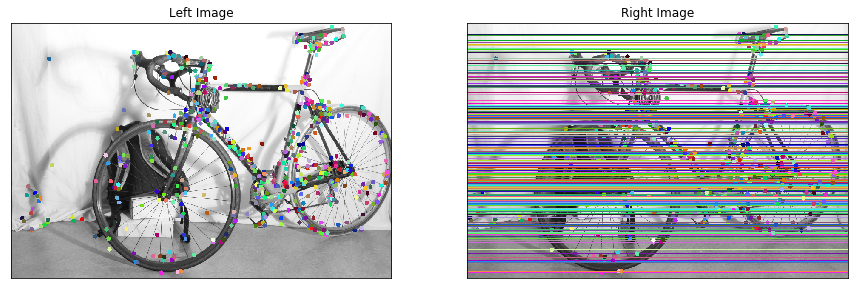

In [5]:
#Create image copies for safekeeping
img0L = img0S.copy()
img1L = img1S.copy()

# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT. Line function only works with keypoints in grayscale. Must find them again
kpL, desL = keypoints1, descriptors1
kpR, desR = keypoints2, descriptors2


# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
notgood = []
ngPtsL = []
ngPtsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
    elif m.distance > 0.8 * n.distance:
        notgood.append(m)
        ngPtsR.append(kpR[m.trainIdx].pt)
        ngPtsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(img0L, img1L, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 2, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(img1L, img0L, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2.3 Pick any one keypoint in the right image which doesn’t have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 × 5) around this keypoint in the right image.


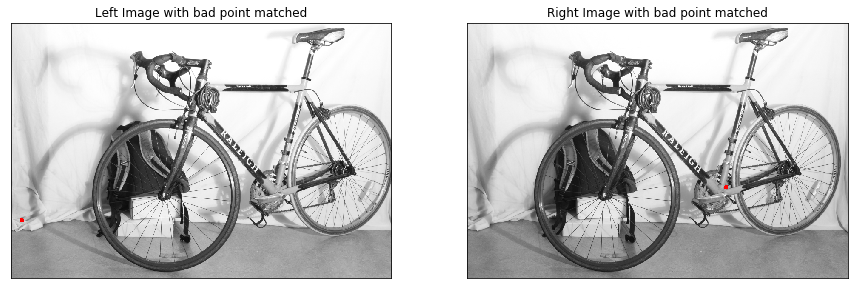

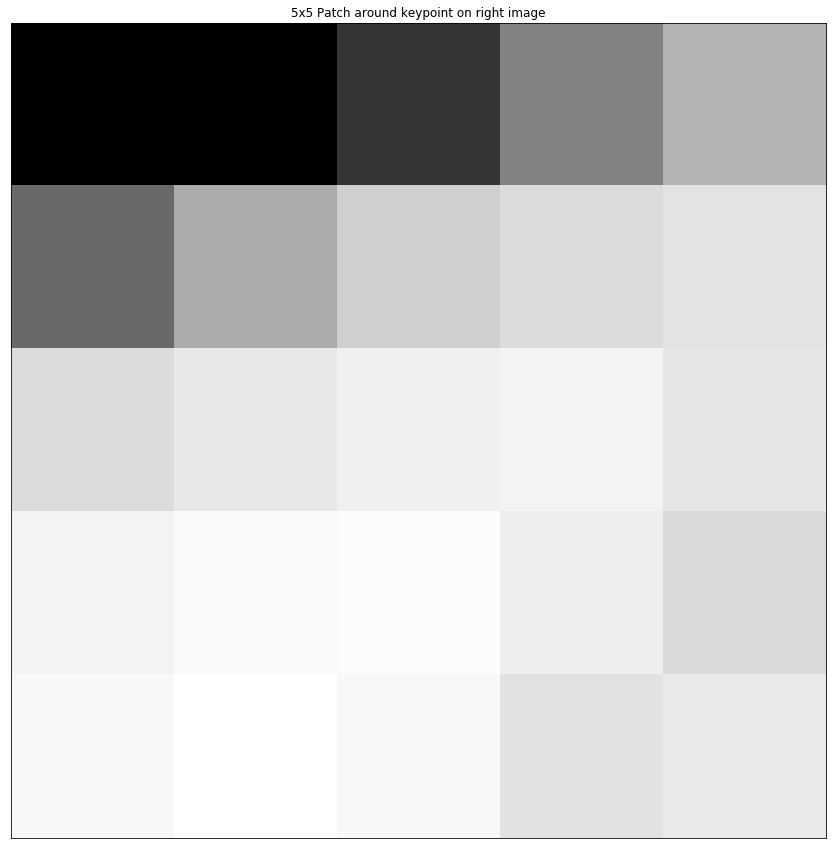

In [95]:
#Create image copies for safekeeping
img0P = img0S.copy()
img1P = img1S.copy()

# convert from grayscale to BGR to be able to put color points.
img0P = cv2.cvtColor(img0P, cv2.COLOR_GRAY2BGR)
img1P = cv2.cvtColor(img1P, cv2.COLOR_GRAY2BGR)

#obtain array of notGood keypoint matches and points
notGoodK = notgood.copy()
badPtsL = ngPtsL.copy()
badPtsR = ngPtsR.copy()

#Pick any one keypoint
leftPt = badPtsL[5]
rightPt = badPtsR[5]

#Draw point on images
lpt = [int(leftPt[0]),int(leftPt[1])]
rpt = [int(rightPt[0]),int(rightPt[1])]
color = (255,0,0)
img0Pdisp = cv2.circle(img0P, (lpt[0],lpt[1]), 5, color, -1)
img1Pdisp = cv2.circle(img1P, (rpt[0],rpt[1]), 5, color, -1)

#Extract 5x5 patch around right image.
patchSize = int((5-1)/2)
patch = img1S[rpt[1]-patchSize:rpt[1]+patchSize+1,rpt[0]-patchSize:rpt[0]+patchSize+1]

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img0Pdisp, cmap="gray")
plt.title("Left Image with bad point matched"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img1Pdisp, cmap="gray")
plt.title("Right Image with bad point matched"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(15,15))
plt.subplot(111),plt.imshow(patch, cmap="gray")
plt.title("5x5 Patch around keypoint on right image"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2.4 Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image.

In [99]:
def _SSDpatch(patch1, patch2):
    SSD = patch1-patch2
    SSD = SSD * SSD
    SSD = sum(sum(SSD))
    return SSD
    

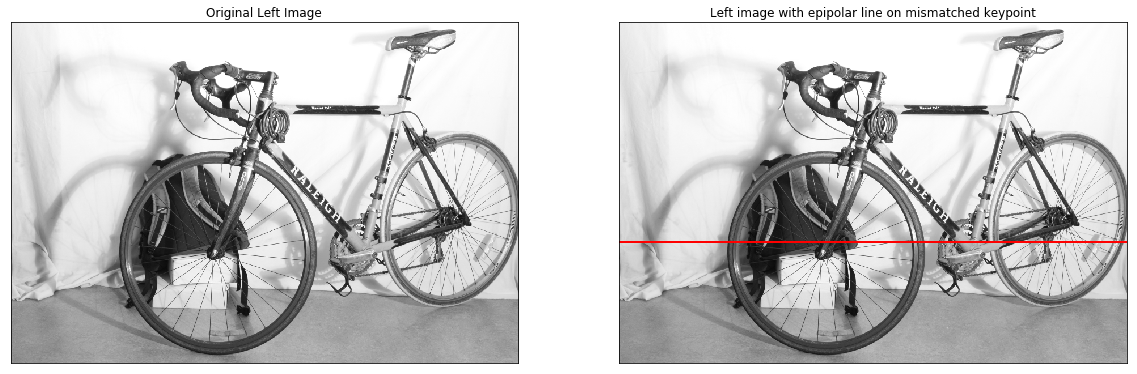

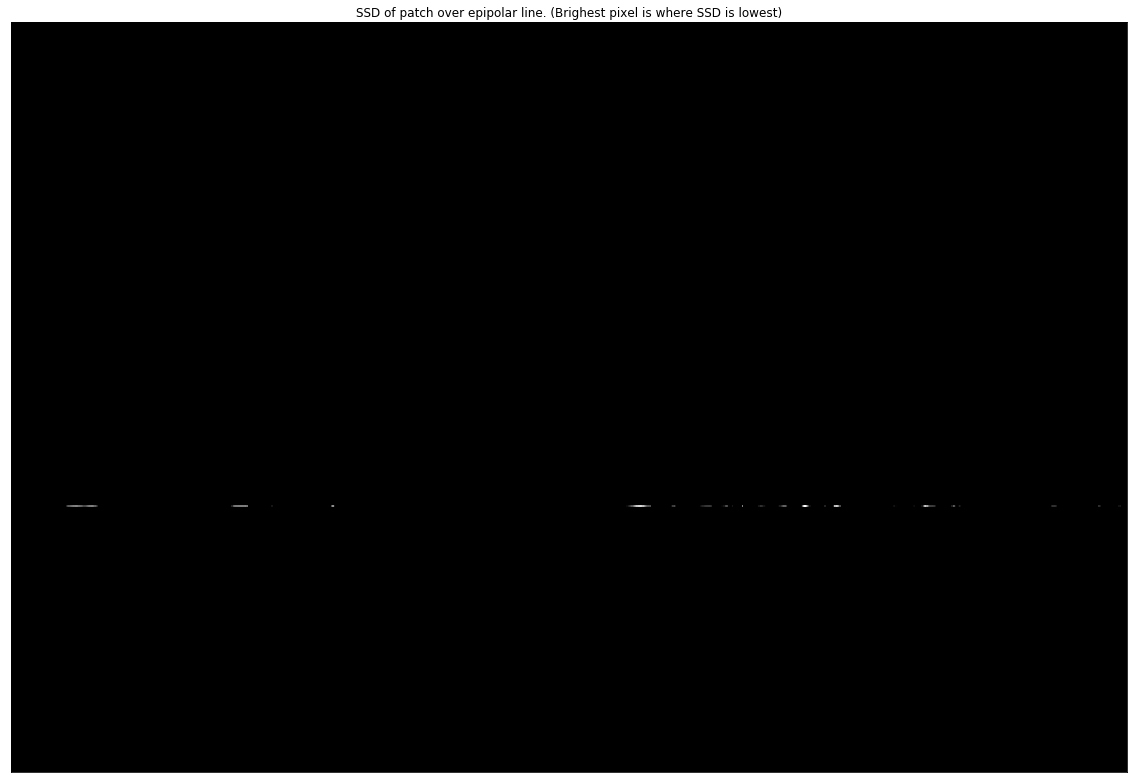

In [163]:
#Create image copies for safekeeping
img0L = img0S.copy()
img1L = img1S.copy()
img0Ldisp = img0S.copy()

# convert from grayscale to BGR to be able to put color line.
img1L = cv2.cvtColor(img1L, cv2.COLOR_GRAY2BGR)
img0Ldisp = cv2.cvtColor(img0Ldisp, cv2.COLOR_GRAY2BGR)
img0L = cv2.cvtColor(img0L, cv2.COLOR_GRAY2BGR)

#Get epipolar line
myRPT = np.array(rpt)
myRPT = myRPT[np.newaxis]
rlines = cv2.computeCorrespondEpilines(myRPT, 2, F)
rlines = rlines[0][0]
x0,y0 = map(int, [0, -rlines[2]/rlines[1]])
x1, y1 = map(int, [img1L.shape[1], -(rlines[2]+rlines[0]*img1L.shape[1])/rlines[1]])

#Draw epipolar line on right image for displaying
color = (255,0,0)
img0Ldisp = cv2.line(img0Ldisp, (x0,y0), (x1,y1), color, 2)

#Find SSD of patch along epipolar line
errorLine = np.zeros(img1L.shape)
line = np.array([img1L.shape[1]])
patchSize2 = int((5-1)/2)
maxErr = 0
maxX = 0
maxY = 0
SSD = np.zeros([img1L.shape[1]-2*patchSize2])
for x in range(img1L.shape[1]-2*patchSize2): #get array of points in line
    x0 = x+patchSize2
    y0 = int(-(rlines[2]+x0*rlines[0])/rlines[1])
    currentImgPatch = img0S[y0-patchSize2:y0+patchSize2+1,x0-patchSize2:x0+patchSize2+1]
    err = _SSDpatch(patch/255,currentImgPatch/255)
    SSD[x] = err
    #Update maxSDD for normalization later
    err = max(0,1-err)
    if(maxErr < err):
        maxErr = err
        maxX ,maxY = x0,y0
    errorLine[y0][x0] = err

#Make sure that the values are not clipped
errorLine = errorLine / maxErr

plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img0L, cmap="gray")
plt.title("Original Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img0Ldisp, cmap="gray")
plt.title("Left image with epipolar line on mismatched keypoint"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(20,20))
plt.subplot(111),plt.imshow(errorLine, cmap="gray")
plt.title("SSD of patch over epipolar line. (Brighest pixel is where SSD is lowest)"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2.5 Plot SSD values (refer Lecture 14 slide 5). Find the matching point with minimum SSD value. Display found matching points in both the images.

Matched point on left image: x= 637 , y= 388


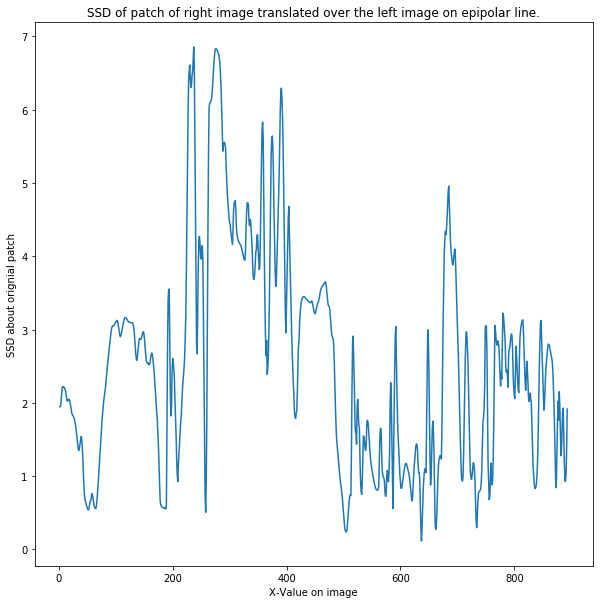

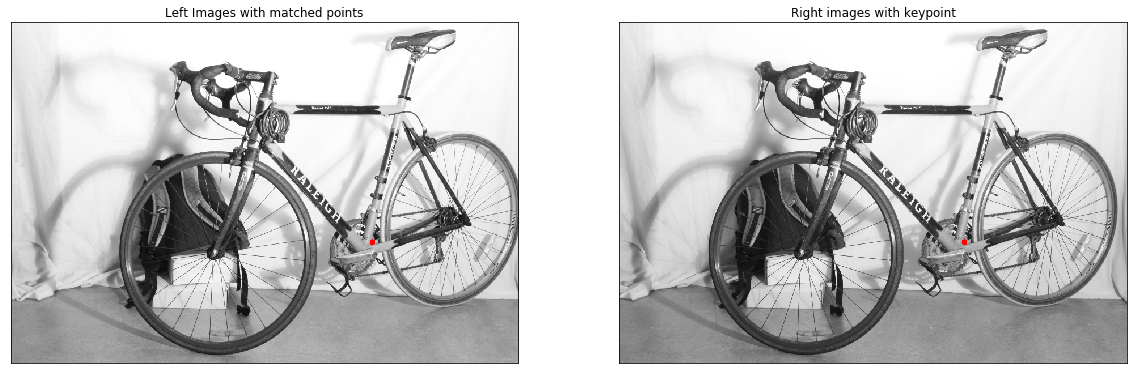

In [170]:
#create copies for safe keeping
SSDdisp = SSD.copy()
img1Mdisp = img1Pdisp.copy()
img0Mdisp = img0S.copy()
img0Mdisp = cv2.cvtColor(img0Mdisp, cv2.COLOR_GRAY2BGR)

#Create index array
ind = range(patchSize2,SSDdisp.shape[0]+patchSize2)

#find lowest SSD
xMatched = np.where(SSDdisp == SSDdisp.min())[0] +patchSize2
yMatched = -(rlines[2]+xMatched*rlines[0])/rlines[1]
yMatched = yMatched.astype(int)

#Create point in resulting left image
color = (255,0,0)
for x,y in zip(xMatched,yMatched):
    print("Matched point on left image: x=",x,", y=",y)
    img0Mdisp = cv2.circle(img0Mdisp, (x,y), 5, color, -1)
    


#Display results
plt.figure(figsize=(10,10))
plt.plot(ind,SSDdisp)
plt.title("SSD of patch of right image translated over the left image on epipolar line.")
plt.xlabel("X-Value on image"), plt.ylabel("SSD about orignial patch")
plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img0Mdisp, cmap="gray")
plt.title("Left Images with matched points"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img1Mdisp, cmap="gray")
plt.title("Right images with keypoint"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2.6 Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

**ANSWER:**  
Exactly one point was found in the left image with the lowest SSD technique. The found matched point is the correct one. If we take a look to the plot above, the minimum SSD point is closely met by other (incorrect) points. Therefore, our matched point came close to being misidentified. Nonetheless, the correct point came out with the lowest SSD and we were able to find it. The lowest SSD calculates the difference in pixel intensities between two patches. Since the real world translation between the two images is relatively small, the two points on the right and left images have very similar intensities and thus a low SSD. 

## 2.2.7 Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?

**ANSWER:**  
Since the images I have been dealing with is in grayscale, we could specifically look at the SSD with RGB color channels. This would increase our accuracy. A bigger patch size could also potentially provide a good way to weed out the bad matches, especially if the point to be matched is found far from the camera and the real world translation of left and right images is small. A bigger patch size would exponetially increase the SSD for bad matches and only proportionally increase the SSD for good matches. 

## 2.2.8 Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?

**ANSWER:**  
Answers from my 2.2.7 applies here also. A wrong match in this situation more than likely arised a point in the foreground of the image with the real world translation between the two cameras being relatively large. Therefore, we could add a geographic maximum distance based on close keypoint features that are a good match. All neighbooring featurs should have very similar transformation matrix and such, we could add a constraint that our mismatched point need to respect the expected transformation. For example, if all the neighbooring points have moved only 10 pixels to the left, we can not expect our mismatched point to be found 100 pixels to the left. The transformation must be coherent with the transformation of the neighboring points. 